In [1]:
import os
import pathlib
import opensmile

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt

In [7]:
data_path = '/tf/data/ADReSS-IS2020' # change this 
audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

In [8]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

In [9]:
meta["ID"] = meta["ID"].str.strip()

In [10]:
ad_files = [str(f) for f in pathlib.Path(audio_path_cd).glob('*.wav')]
control_files = [str(f) for f in pathlib.Path(audio_path_cc).glob('*.wav')]

In [11]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [ ]:
ad_data = smile.process_files(ad_files)
control_data = smile.process_files(control_files)

In [ ]:
def add_MMSE(data):
    data.reset_index(inplace=True)
    data["filename"] = data["file"].str.split("/").str[-1].str.split('.wav').str[0]
    data = data.merge(meta[["ID", "MMSE"]], how="inner", left_on="filename", right_on="ID").drop(["ID","filename"], axis=1)
    data.set_index(["file","start","end"], inplace=True)
    return data

ad_data = add_MMSE(ad_data)
control_data = add_MMSE(control_data)

In [ ]:
data = pd.concat([ad_data,control_data])

In [ ]:
data = data.sample(frac=1)

In [ ]:
data = data[data["MMSE"]!=' NA']
data["MMSE"] = data["MMSE"].astype(float)

In [ ]:
data

In [17]:
train_cutoff = int(len(data)*0.7)
val_cutoff = int(len(data)*0.85)

train = data[:train_cutoff]
val = data[train_cutoff:val_cutoff]
test = data[val_cutoff:]

train_x = train.drop("MMSE", axis=1).to_numpy()
train_y = train["MMSE"].to_numpy()

val_x = val.drop("MMSE", axis=1).to_numpy()
val_y = val["MMSE"].to_numpy()

test_x = test.drop("MMSE", axis=1).to_numpy()
test_y = test["MMSE"].to_numpy()

In [18]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_x)

model = models.Sequential([
    layers.Input(shape=(6373,)),
    norm_layer,
    layers.Dense(2056, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='relu')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6373)              12747     
_________________________________________________________________
dense (Dense)                (None, 2056)              13104944  
_________________________________________________________________
dropout (Dropout)            (None, 2056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1053184   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [19]:
model.compile(
    optimizer="adam",
    loss='mse',
    metrics=[tf.keras.losses.MeanSquaredError()]
)

In [20]:
EPOCHS = 100
history = model.fit(
    train_x,
    train_y,
    batch_size=64,
    epochs=EPOCHS,
    validation_data=(val_x, val_y)
)

Epoch 1/100
2/2 [==============================] - 0s 136ms/step - loss: 540.9540 - mean_squared_error: 483.1759 - val_loss: 151880881668096.0000 - val_mean_squared_error: 151880881668096.0000
Epoch 2/100
2/2 [==============================] - 0s 43ms/step - loss: 191.9819 - mean_squared_error: 303.6315 - val_loss: 247317101805568.0000 - val_mean_squared_error: 247317101805568.0000
Epoch 3/100
2/2 [==============================] - 0s 44ms/step - loss: 451.3779 - mean_squared_error: 401.9698 - val_loss: 75440236527616.0000 - val_mean_squared_error: 75440236527616.0000
Epoch 4/100
2/2 [==============================] - 0s 42ms/step - loss: 150.2363 - mean_squared_error: 169.1676 - val_loss: 26244422828032.0000 - val_mean_squared_error: 26244422828032.0000
Epoch 5/100
2/2 [==============================] - 0s 42ms/step - loss: 221.5382 - mean_squared_error: 223.5120 - val_loss: 21346710978560.0000 - val_mean_squared_error: 21346710978560.0000
Epoch 6/100
2/2 [============================

2/2 [==============================] - 0s 42ms/step - loss: 119.2170 - mean_squared_error: 123.0833 - val_loss: 2816329121792.0000 - val_mean_squared_error: 2816329121792.0000
Epoch 45/100
2/2 [==============================] - 0s 51ms/step - loss: 85.0081 - mean_squared_error: 84.8463 - val_loss: 2980385390592.0000 - val_mean_squared_error: 2980385390592.0000
Epoch 46/100
2/2 [==============================] - 0s 43ms/step - loss: 93.5503 - mean_squared_error: 88.2053 - val_loss: 3197898063872.0000 - val_mean_squared_error: 3197898063872.0000
Epoch 47/100
2/2 [==============================] - 0s 45ms/step - loss: 101.2077 - mean_squared_error: 128.2963 - val_loss: 3212451250176.0000 - val_mean_squared_error: 3212451250176.0000
Epoch 48/100
2/2 [==============================] - 0s 45ms/step - loss: 99.1472 - mean_squared_error: 132.3317 - val_loss: 2998077227008.0000 - val_mean_squared_error: 2998077227008.0000
Epoch 49/100
2/2 [==============================] - 0s 47ms/step - loss: 

Epoch 88/100
2/2 [==============================] - 0s 42ms/step - loss: 70.4503 - mean_squared_error: 61.4323 - val_loss: 2863452127232.0000 - val_mean_squared_error: 2863452127232.0000
Epoch 89/100
2/2 [==============================] - 0s 46ms/step - loss: 48.1733 - mean_squared_error: 46.7187 - val_loss: 2752644382720.0000 - val_mean_squared_error: 2752644382720.0000
Epoch 90/100
2/2 [==============================] - 0s 42ms/step - loss: 54.6174 - mean_squared_error: 50.1746 - val_loss: 2964086587392.0000 - val_mean_squared_error: 2964086587392.0000
Epoch 91/100
2/2 [==============================] - 0s 46ms/step - loss: 76.6128 - mean_squared_error: 75.8087 - val_loss: 3095869784064.0000 - val_mean_squared_error: 3095869784064.0000
Epoch 92/100
2/2 [==============================] - 0s 42ms/step - loss: 57.2012 - mean_squared_error: 55.6522 - val_loss: 3110464913408.0000 - val_mean_squared_error: 3110464913408.0000
Epoch 93/100
2/2 [==============================] - 0s 43ms/step 

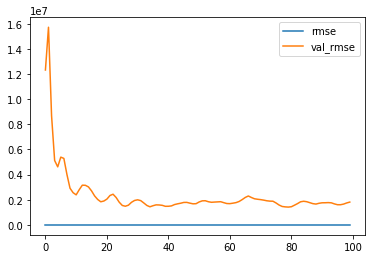

In [21]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mean_squared_error']), np.sqrt(metrics['val_mean_squared_error']))
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [22]:
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=64)
print("test rmse:", np.sqrt(results)[0])

Evaluate on test data
1/1 [==============================] - 0s 13ms/step - loss: 128.3374 - mean_squared_error: 128.3374
test rmse: 11.328609229952322
